# LDA Topic Modeling

In [1]:
import re, sys, codecs, calendar, random, pickle
import numpy as np, pandas as pd, matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from pprint import pprint
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from IPython.display import Image, display; 
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib._color_data as mcd

# NLP-related
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from textblob import TextBlob
# import pathlib, inflect
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')
# !{sys.executable} -m spacy download en
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

remc=["navy","white","snow","whitesmoke","seashell","honeydrew","ivory","lightyellow","beige",'lavender',
      "floralwhite","mintcream","azure","alicblue","lavenderblush","ghostwhite","lightblue","lightgreen"]
tableau_cl=[c[4:] for c in mcolors.TABLEAU_COLORS] #10 colors
xkcd_cl=[c for c in list({name for name in mcd.CSS4_COLORS
         if "xkcd:" + name in mcd.XKCD_COLORS}) if c not in remc] #45 colors
css4_cl=[c for c in mcolors.CSS4_COLORS if c not in remc] # 136 colors

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# # Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

### Importing raw data

In [2]:
datafile = 'SCOPUS Disease Control through Social Network Surveillance.csv' 
name = "Disease Control through Social Network Surveillance"
st = "Scopus bibliometric dataset on %s" %name

In [3]:
df = pd.read_csv(datafile, sep=',', encoding="utf-8")
# df = df.reset_index(drop=True)
print(df.columns)
df=df[['Authors', 'Title', 'Year', 'Source title', 'Author Keywords', 'Index Keywords', 'Abstract']]
print(len(df))
df.head(3)

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Volume',
       'Issue', 'Art. No.', 'Page start', 'Page end', 'Page count', 'Cited by',
       'DOI', 'Link', 'Affiliations', 'Authors with affiliations', 'Abstract',
       'Author Keywords', 'Index Keywords', 'Funding Details',
       'Funding Text 1', 'Funding Text 2', 'Funding Text 3', 'References',
       'Correspondence Address', 'Editors', 'Publisher', 'ISSN', 'ISBN',
       'CODEN', 'PubMed ID', 'Language of Original Document',
       'Abbreviated Source Title', 'Document Type', 'Publication Stage',
       'Access Type', 'Source', 'EID'],
      dtype='object')
939


,Authors,Title,Year,Source title,Author Keywords,Index Keywords,Abstract
0,"Band J.D., Chamberland M.E., Platt T., Weaver ...",Trends in meningococcal disease in the United ...,1983,Journal of Infectious Diseases,NaN,clinical article; epidemiology; geographic dis...,"The Center for Disease Control (CDC), Atlanta,..."
1,"Kaewsonthi S., Harding A.G.",Cost and performance of malaria surveillance i...,1984,Social Science and Medicine,NaN,article; cost benefit analysis; developing cou...,Some results are presented from a study to det...
2,"Zessin K.-H., Carpenter T.E.",Benefit-cost analysis of an epidemiologic appr...,1985,Preventive Veterinary Medicine,NaN,NaN,The economic potential of two alternatives: (1...


In [4]:
sorted(df.Year.unique())

[1983,
 1984,
 1985,
 1987,
 1988,
 1989,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

In [5]:
Publication=[]
Abstract=[]
s=0
s1=0
for i in range(len(df)):   
    a=df.iloc[i]['Authors']
    b=df.iloc[i]['Year']
    c=df.iloc[i]['Title']
    ab=df.iloc[i]['Abstract']
    if ab=='[No abstract available]':
        ab=c
    else:
        ab=ab
    Abstract.append(ab)
    if c.count(" ")<4:
        if c[-1]==".":
            cc=c[:-1]
        else:
            cc=c
    else:
        cl=c.split(" ")[:3]
        cc=" ".join(cl)+" ..."
    cl=c.split(" ")
    if a!='[No author name available]':
        if a.count(",")==0:
            if a.count(" ")>1:
                al=a.split(" ")
                al=al[:-1]
                aa=" ".join(al)+" ("+str(b)+")"+" "+cc
                Publication.append(aa)
            else:
                al=a.split(" ")
                aa=al[0].title()+" ("+str(b)+")"+" "+cc
                Publication.append(aa)
        elif a.count(",")==1:
            a1=a.split(", ")[0]
            if a1.count(" ")>1:
                al=a1.split(" ")
                al=al[:-1]
                aa1=" ".join(al)
            else:
                al=a1.split(" ")
                aa1=al[0]
            a2=a.split(", ")[1]
            if a2.count(" ")>1:
                al=a1.split(" ")
                al=al[:-1]
                aa2=" ".join(al)
            else:
                al=a2.split(" ")
                aa2=al[0]
            aa=aa1.title()+" & "+aa2.title()+" ("+str(b)+")"+" "+cc
            Publication.append(aa)
        else:
            if a.startswith("Rosenthal") and b==2018:
                al=a.split(", ")[0]
                if al.count(" ")>1:
                    aal=al.split(" ")
                    aal=aal[:-1]
                    aa=" ".join(aal) #+", "
                else:
                    aal=al.split(" ")
                    aa=aal[0] #+", "
                aa=aa.title()+" et al."+" "+str(s1)+" ("+str(b)+")"+" "+cc
                s1+=1
            else:    
                al=a.split(", ")[0]
                if al.count(" ")>1:
                    aal=al.split(" ")
                    aal=aal[:-1]
                    aa=" ".join(aal) #+", "
                else:
                    aal=al.split(" ")
                    aa=aal[0] #+", "
                aa=aa.title()+" et al."+" ("+str(b)+")"+" "+cc
            Publication.append(aa)
    else:
        aa="No authors "+str(s)+" ("+str(b)+")"
        Publication.append(aa)
        s+=1
data_size=len(df)
if len(Publication)==len(df):
    print(data_size,"publications in the dataset")
else:
    print("SOMETHING IS WRONG")
df["Publication"]=Publication
df["Abstract"]=Abstract
df=df[["Publication","Abstract"]]
df.head(3)

939 publications in the dataset


,Publication,Abstract
0,Band et al. (1983) Trends in meningococcal ...,"The Center for Disease Control (CDC), Atlanta,..."
1,Kaewsonthi & Harding (1984) Cost and performan...,Some results are presented from a study to det...
2,Zessin & Carpenter (1985) Benefit-cost analysi...,The economic potential of two alternatives: (1...


In [6]:
docs_d={}
for i in range(len(df)):   
    k=df.iloc[i]['Publication']
    v=df.iloc[i]['Abstract']
    docs_d[k]=v
print(len(docs_d))
# docs_d

939


### Word tokenization

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = df.Abstract.values.tolist()
data_words = list(sent_to_words(data))

# Random document/diary
while True: 
    q=random.randrange(data_size)
    if len(list(docs_d.values())[q])>0:
        break
# print(q,list(docs_d.values())[q],'\n')

# print(q,data_words[q])

# def sent_to_words(sentences):
#     for sent in sentences:
#         sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
#         sent = re.sub('\s+', ' ', sent)  # remove newline chars
#         sent = re.sub("\'", "", sent)  # remove single quotes
#         sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
#         yield(sent)  

# # Convert to list
# data = df.Diary.values.tolist()
# data_words = list(sent_to_words(data))
# print(data_words[:1])
# # [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

### Creating Bigram and Trigram Models

In [8]:
# Threshold: higher threshold fewer phrases
threshold=100

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=threshold) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=threshold)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# print("bigrams",bigram[data_words[0]],len(bigram[data_words[0]]),'\n')
# print("bigrams_mod",bigram_mod[data_words[0]],len(bigram_mod[data_words[0]]),'\n')
# print("trigrams",trigram[data_words[0]],len(trigram[data_words[0]]),'\n')
# print("trigrams_mod",trigram_mod[data_words[0]],len(trigram_mod[data_words[0]]),'\n')
# # print("trigrams_mod_1",trigram_mod[bigram_mod[data_words[0]]],len(trigram_mod[data_words[0]]))

### Removing stopwords, making bigrams and lemmatizing

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Random document/diary
while True: 
    q=random.randrange(data_size)
    if len(list(docs_d.values())[q])>0:
        break
# print(q,list(docs_d.values())[q],'\n')

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# print(data_words_bigrams[q],'\n')

# data_words_trigrams = make_trigrams(data_words_nostops)
# print(data_words_trigrams[q],'\n')

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print(data_lemmatized[q])

In [11]:
# # PROCESSING WITHOUT LEMMATIZATION (data_lemmatized --> data_ready)

# def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
#     texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
#     texts = [bigram_mod[doc] for doc in texts]
#     texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
#     texts_out = []
#     nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     # remove stopwords once more after lemmatization
#     texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
#     return texts_out

# data_ready = process_words(data_words)  # processed Text Data!

### Creating the Dictionary and Corpus needed for Topic Modeling

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# # View
# print(corpus[q],'\n')
# # Human readable format of corpus (term-frequency)
# nc=[(id2word[cp[0]], cp[1]) for cp in corpus[q]]
# print(nc)

### Building LDA Topic Model

Num Topics = 0  has Coherence Value of 0.4248
Num Topics = 6  has Coherence Value of 0.4288
Num Topics = 12  has Coherence Value of 0.448
Num Topics = 18  has Coherence Value of 0.4432
Num Topics = 24  has Coherence Value of 0.4362
Num Topics = 30  has Coherence Value of 0.4293
Num Topics = 36  has Coherence Value of 0.4152


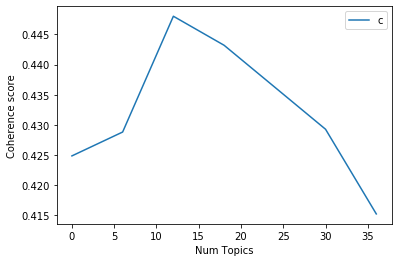

In [13]:
with open('coherence_values.pkl', 'rb') as f:
    coherence_values = pickle.load(f)
limit=40; start=0; step=6;
x = range(start, limit, step)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
display(Image(filename='CoherenceScores.png'))

In [14]:
# Build LDA model
num_topics=12 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50, #10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# lda_model.show_topic(6, topn=100)

In [16]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

[(0,
  '0.039*"model" + 0.039*"risk" + 0.032*"network" + 0.029*"study" + '
  '0.027*"use" + 0.019*"disease" + 0.016*"factor" + 0.013*"analysis" + '
  '0.011*"predict" + 0.011*"base"'),
 (1,
  '0.018*"case" + 0.017*"epidemic" + 0.017*"control" + 0.014*"transmission" + '
  '0.013*"country" + 0.012*"region" + 0.011*"high" + 0.010*"global" + '
  '0.010*"treatment" + 0.010*"human"'),
 (2,
  '0.025*"bioterrorism" + 0.007*"depict" + 0.000*"beneficial" + '
  '0.000*"anthrax" + 0.000*"orcategory" + 0.000*"mailing" + 0.000*"categoric" '
  '+ 0.000*"cap" + 0.000*"theparticipant" + 0.000*"anthracis"'),
 (3,
  '0.046*"compliance" + 0.009*"deal" + 0.006*"typhoid" + 0.000*"enrichment" + '
  '0.000*"cw" + 0.000*"signifi" + 0.000*"can" + 0.000*"stay_lo" + '
  '0.000*"procedural" + 0.000*"correlation_coefficient"'),
 (4,
  '0.057*"death" + 0.043*"injury" + 0.041*"pneumococcal" + 0.028*"protective" '
  '+ 0.027*"algorithm" + 0.018*"rule" + 0.016*"invasive" + 0.015*"fall" + '
  '0.014*"traumatic" + 0.014*

In [17]:
[" ".join([z[7:].replace('"','') for z in y[1].split(" + ")]) for y in lda_model.print_topics()]

['model risk network study use disease factor analysis predict base',
 'case epidemic control transmission country region high global treatment human',
 'bioterrorism depict beneficial anthrax orcategory mailing categoric cap theparticipant anthracis',
 'compliance deal typhoid enrichment cw signifi can stay_lo procedural correlation_coefficient',
 'death injury pneumococcal protective algorithm rule invasive fall traumatic senior',
 'animal farm movement network market pig structure spread disease trade',
 'outbreak case report food identify isolate person cluster investigation sample',
 'suicide dialysis hemodialysis differ overdose vascular_access varied ml arteriovenous frequency',
 'infection rate patient associate surveillance study hospital day center result',
 'influenza year estimate child age prevalence population case incidence increase',
 'disease surveillance laboratory infectious network outbreak response control emerge clinical',
 'health datum surveillance system public

In [18]:
topic_interpetation={0:'model',
                     1:'epidemic case',
                     2:'bioterrorism',
                     3:'compliance',
                     4:'death',
                     5:'animal',
                     6:'outbreak',
                     7:'suicide',
                     8:'infection',
                     9:'influenza',
                     10:'disease control',
                     11:'surveillance system'
                    }

### Model Perplexity and Coherence Score

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.907722565491177

Coherence Score:  0.40855699702114495


### Topics visualization

In [20]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
# vis

### Building LDA Mallet Model

In [21]:
# # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

In [22]:
# # Show Topics
# pprint(ldamallet.show_topics(formatted=False))

# # Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)

In [23]:
# [" ".join([z[7:].replace('"','') for z in y[1].split(" + ")]) for y in ldamallet.show_topics()]

### Finding optimal number of topics

In [24]:
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     """
#     Compute c_v coherence for various number of topics

#     Parameters:
#     ----------
#     dictionary : Gensim dictionary
#     corpus : Gensim corpus
#     texts : List of input texts
#     limit : Max num of topics

#     Returns:
#     -------
#     model_list : List of LDA topic models
#     coherence_values : Coherence values corresponding to the LDA model with respective number of topics
#     """
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values

In [25]:
# # Can take a long time to run.
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [26]:
# # Show graph
# limit=40; start=0; step=6;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [27]:
# # Print the coherence scores
# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [28]:
# with open('coherence_values.pkl', 'wb') as f:
#     pickle.dump(coherence_values, f)

### Finding the dominant topic in each publication

In [29]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data) #_lemmatized

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.3679,"health, datum, surveillance, system, public, n...","The Center for Disease Control (CDC), Atlanta,..."
1,1,11.0,0.6493,"health, datum, surveillance, system, public, n...",Some results are presented from a study to det...
2,2,11.0,0.3595,"health, datum, surveillance, system, public, n...",The economic potential of two alternatives: (1...
3,3,11.0,0.5328,"health, datum, surveillance, system, public, n...",The epidemiology surveillance project: A compu...
4,4,11.0,0.4735,"health, datum, surveillance, system, public, n...",18 of the 1990 health objectives for the U.S. ...
5,5,9.0,0.4144,"influenza, year, estimate, child, age, prevale...",Respondents in the 1988 General Social Survey ...
6,6,11.0,0.3261,"health, datum, surveillance, system, public, n...",In the context of a surveillance programme for...
7,7,1.0,0.4566,"case, epidemic, control, transmission, country...",The World Health Organization (WHO) pays great...
8,8,10.0,0.3815,"disease, surveillance, laboratory, infectious,...",The French Communicable Diseases Computer Netw...
9,9,11.0,0.4264,"health, datum, surveillance, system, public, n...",The evaluation of the IVDK as an epidemiologic...


### Find the most representative publication for each topic

In [30]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.5790,"model, risk, network, study, use, disease, factor, analysis, predict, base","The surveillance, analysis and ultimately the efficient long-term prediction and control of epid..."
1,1.0,0.7226,"case, epidemic, control, transmission, country, region, high, global, treatment, human",In the forests of Cote d'Ivoire a surveillance network is needed to quickly and continuously det...
2,5.0,0.4235,"animal, farm, movement, network, market, pig, structure, spread, disease, trade","Within Great Britain cattle are often traded at regional markets, of which there are approximate..."
3,6.0,0.6197,"outbreak, case, report, food, identify, isolate, person, cluster, investigation, sample",BACKGROUND: Produce-associated outbreaks of Shiga toxin-producing Escherichia coli (STEC) were f...
4,8.0,0.8574,"infection, rate, patient, associate, surveillance, study, hospital, day, center, result",Background: Central line–associated bloodstream infections are serious life-threatening infectio...
5,9.0,0.6341,"influenza, year, estimate, child, age, prevalence, population, case, incidence, increase",Background: The effectiveness of influenza vaccine among nursery school children has not been sy...
6,10.0,0.6296,"disease, surveillance, laboratory, infectious, network, outbreak, response, control, emerge, cli...","PulseNet, the national molecular subtyping network for foodborne disease surveillance, was estab..."
7,11.0,0.9328,"health, datum, surveillance, system, public, network, information, provide, national, use",CDC WONDER is an information management architecture designed for public health. It provides acc...


### Topic distribution across publications

In [31]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,11.0,"health, datum, surveillance, system, public, network, information, provide, national, use",34.0,0.0362
1.0,11.0,"health, datum, surveillance, system, public, network, information, provide, national, use",128.0,0.1363
2.0,11.0,"health, datum, surveillance, system, public, network, information, provide, national, use",NaN,NaN
3.0,11.0,"health, datum, surveillance, system, public, network, information, provide, national, use",NaN,NaN
4.0,11.0,"health, datum, surveillance, system, public, network, information, provide, national, use",NaN,NaN
...,...,...,...,...
934.0,1.0,"case, epidemic, control, transmission, country, region, high, global, treatment, human",NaN,NaN
935.0,8.0,"infection, rate, patient, associate, surveillance, study, hospital, day, center, result",NaN,NaN
936.0,9.0,"influenza, year, estimate, child, age, prevalence, population, case, incidence, increase",NaN,NaN
937.0,6.0,"outbreak, case, report, food, identify, isolate, person, cluster, investigation, sample",NaN,NaN


### Frequency distribution of word counts in publications

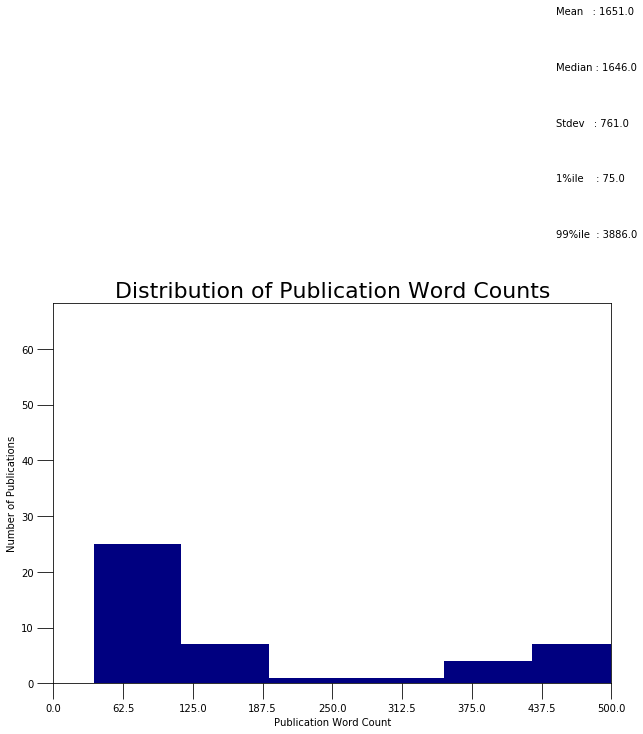

In [32]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10,7)) #, dpi=160)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(450,  120, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(450,  110, "Median : " + str(round(np.median(doc_lens))))
plt.text(450,  100, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(450,  90, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(450,  80, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Publications', xlabel='Publication Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,500,9))
plt.title('Distribution of Publication Word Counts', fontdict=dict(size=22))
plt.show()

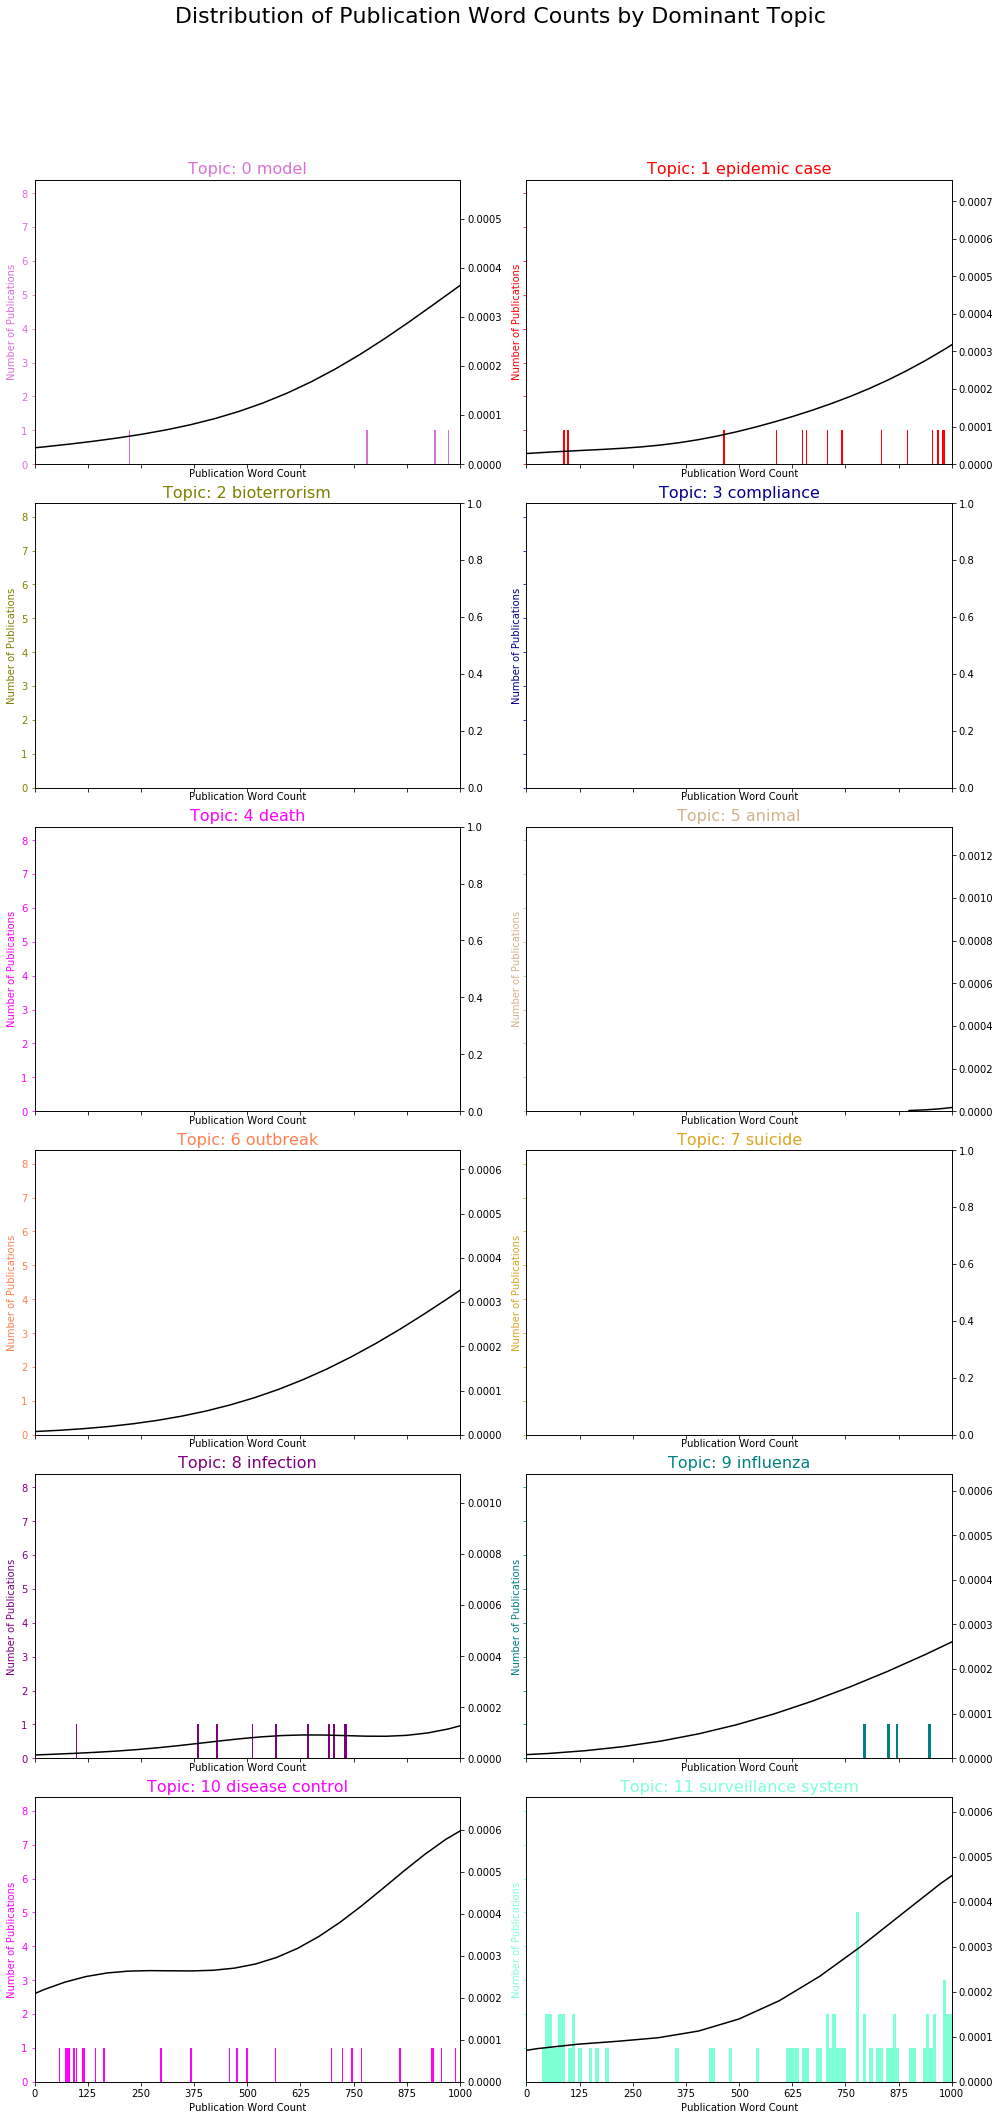

In [33]:
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
# cols = [color for name, color in mcolors.XKCD_COLORS.items()]
cols=xkcd_cl

fig, axes = plt.subplots(6,2,figsize=(14,30), sharex=True, sharey=True) #dpi=160, 

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Publication Word Count')
    ax.set_ylabel('Number of Publications', color=cols[i])
    ax.set_title('Topic: '+str(i)+" "+topic_interpetation[i], fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Publication Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [34]:
for i, ax in enumerate(axes.flatten()):    
    print(i,cols[i])

0 orchid
1 red
2 olive
3 darkblue
4 magenta
5 tan
6 coral
7 goldenrod
8 purple
9 teal
10 fuchsia
11 aquamarine


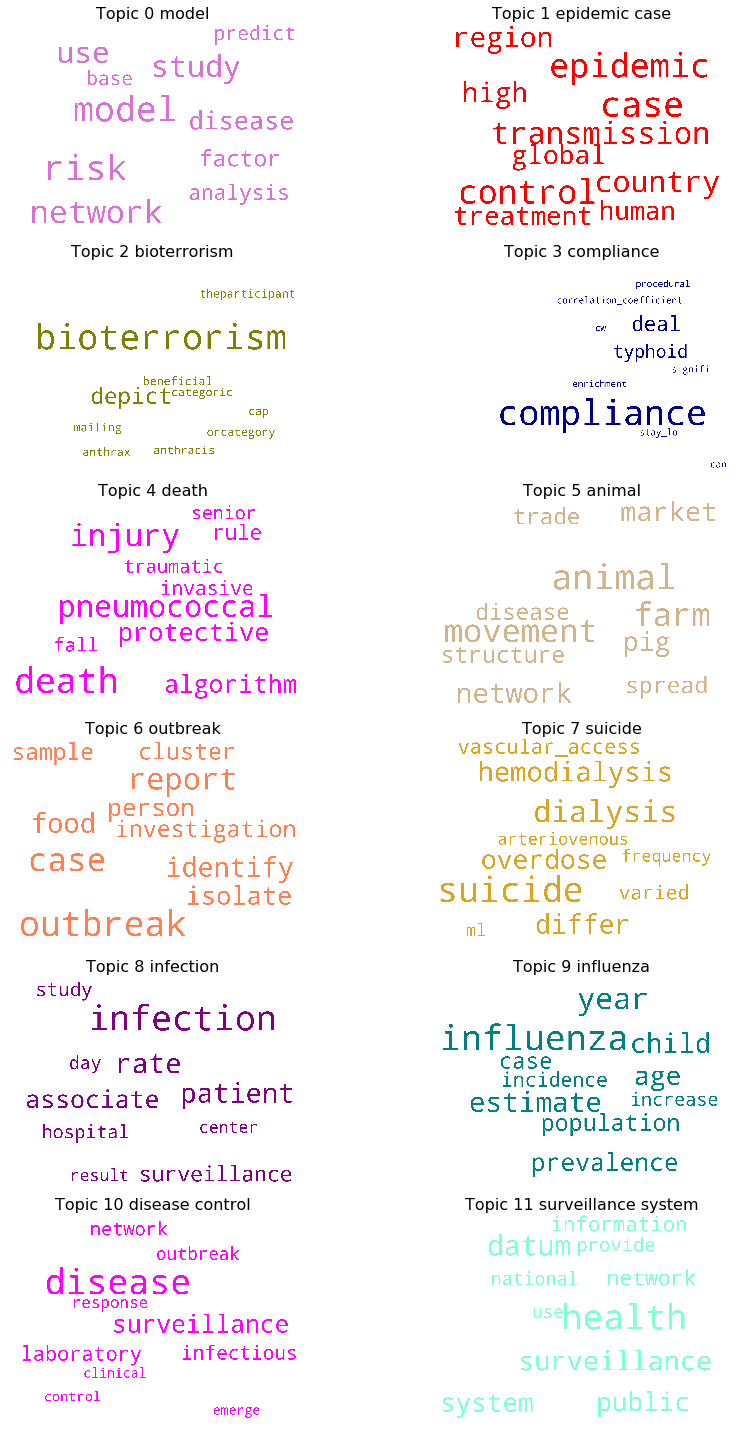

In [35]:
# 1. Wordcloud of Top N words in each topic

# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
# cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

# topics = lda_model.show_topics(formatted=False)
topics = lda_model.show_topics(num_topics=num_topics,formatted=False)

fig, axes = plt.subplots(6,2, figsize=(14,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i)+" "+topic_interpetation[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

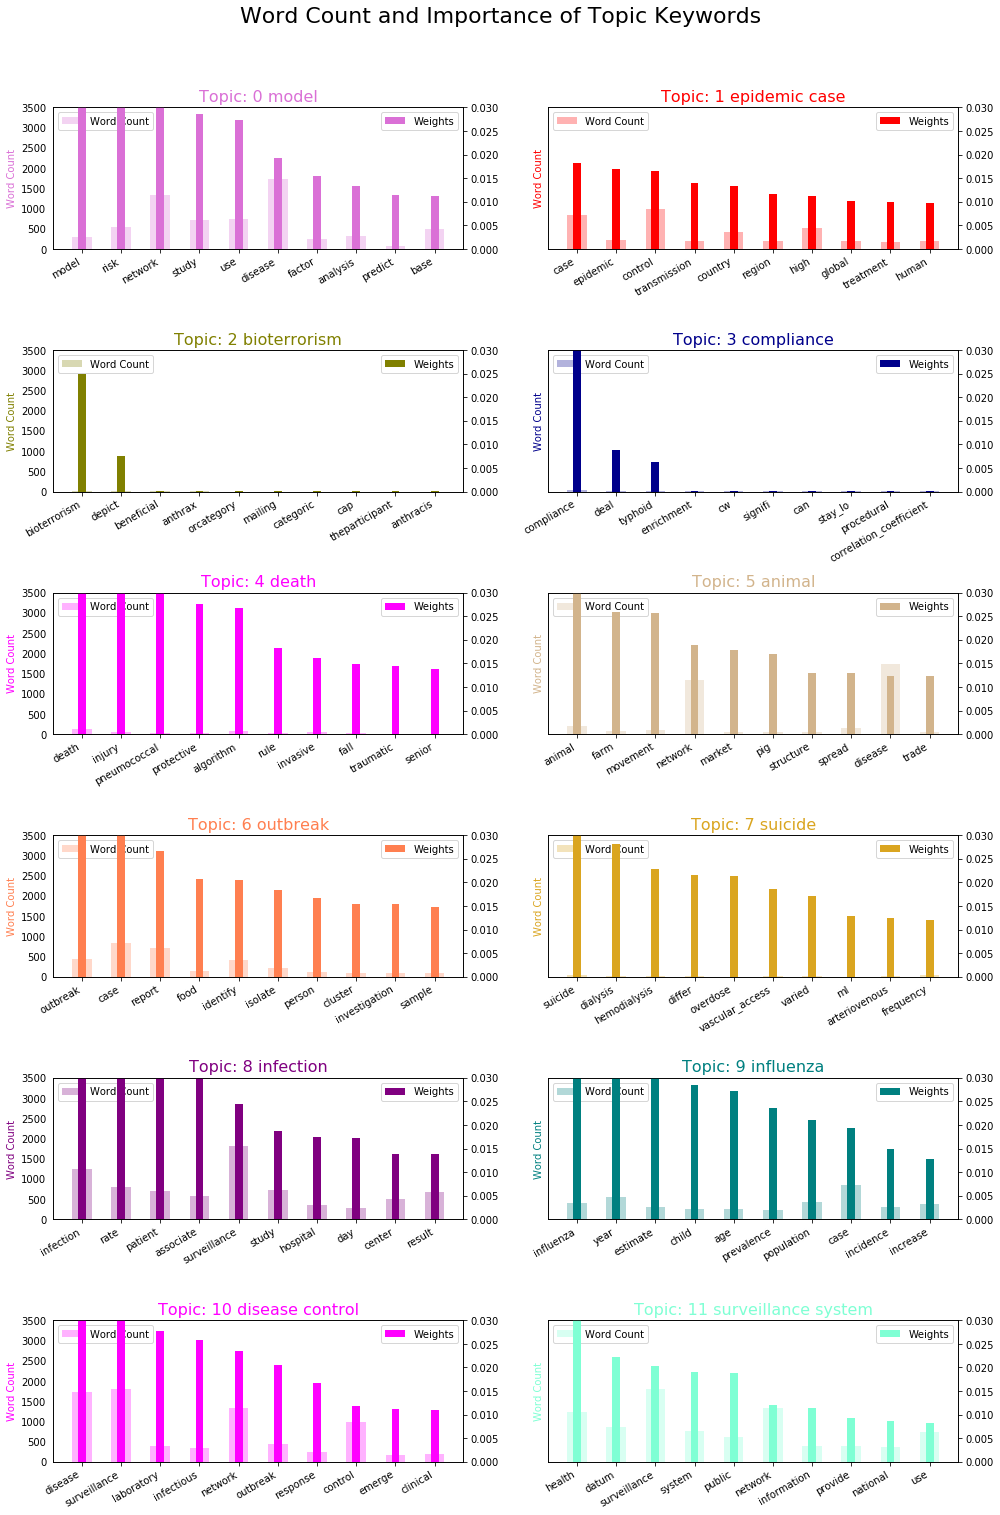

In [36]:
# topics = lda_model.show_topics(formatted=False)
topics = lda_model.show_topics(num_topics=num_topics,formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(6, 2, figsize=(14,20), sharey=True) #, dpi=160
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
# cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i)+" "+topic_interpetation[i], color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [37]:
# # Sentence Coloring of N Sentences

# def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
#     corp = corpus[start:end]
# #     mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
#     mycolors = [color for name, color in mcolors.XKCD_COLORS.items()]

#     fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95)) #, dpi=160)       
#     axes[0].axis('off')
#     for i, ax in enumerate(axes):
#         if i > 0:
#             corp_cur = corp[i-1] 
#             topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
#             word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
#             ax.text(0.01, 0.5, "Publ " + str(i-1) + ": ", verticalalignment='center',
#                     fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

#             # Draw Rectange
#             topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
#             ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
#                                    color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

#             word_pos = 0.06
#             for j, (word, topics) in enumerate(word_dominanttopic):
#                 if j < 14:
#                     ax.text(word_pos, 0.5, word,
#                             horizontalalignment='left',
#                             verticalalignment='center',
#                             fontsize=16, color=mycolors[topics],
#                             transform=ax.transAxes, fontweight=700)
#                     word_pos += .009 * len(word)  # to move the word for the next iter
#                     ax.axis('off')
#             ax.text(word_pos, 0.5, '. . .',
#                     horizontalalignment='left',
#                     verticalalignment='center',
#                     fontsize=16, color='black',
#                     transform=ax.transAxes)       

#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
#     plt.tight_layout()
#     plt.show()

# sentences_chart()  

In [38]:
# # Sentence Coloring of N Sentences
# def topics_per_document(model, corpus, start=0, end=1):
#     corpus_sel = corpus[start:end]
#     dominant_topics = []
#     topic_percentages = []
#     for i, corp in enumerate(corpus_sel):
#         topic_percs, wordid_topics, wordid_phivalues = model[corp]
#         dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
#         dominant_topics.append((i, dominant_topic))
#         topic_percentages.append(topic_percs)
#     return(dominant_topics, topic_percentages)

# dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# # Distribution of Dominant Topics in Each Document
# df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
# dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
# df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# # Total Topic Distribution by actual weight
# topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
# df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# # Top 3 Keywords for each Topic
# topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
#                                  for j, (topic, wt) in enumerate(topics) if j < 3]

# df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
# df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
# df_top3words.reset_index(level=0,inplace=True)

In [39]:
# # Plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True) #dpi=120, 

# # Topic Distribution by Dominant Topics
# ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
# ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
# tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
# ax1.xaxis.set_major_formatter(tick_formatter)
# ax1.set_title('Number of Publications by Dominant Topic', fontdict=dict(size=10))
# ax1.set_ylabel('Number of Publications')
# ax1.set_ylim(0, 1000)

# # Topic Distribution by Topic Weights
# ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
# ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
# ax2.xaxis.set_major_formatter(tick_formatter)
# ax2.set_title('Number of Publications by Topic Weightage', fontdict=dict(size=10))

# plt.show()

In [40]:
# Get topic weights and dominant topics ------------

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 12
# mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
mycolors = np.array(cols) #[color for name, color in mcolors.XKCD_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 699 samples in 0.001s...
[t-SNE] Computed neighbors for 699 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 699 / 699
[t-SNE] Mean sigma: 0.137117
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.776142
[t-SNE] KL divergence after 1000 iterations: 0.523122


Loading BokehJS ...